# Import modules

In [1]:
import os
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [4]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Functions

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Read in adata

In [29]:
adata_oct_healthy = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')
print(adata_oct_healthy.shape)
adata_oct_t21 = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-T21_foetal_raw.h5ad')
print(adata_oct_t21.shape)

(14261, 33538)
(11238, 33538)


In [30]:
# concatenate oct adata
adata_oct_healthy.obs['status'] = 'Euploid'
adata_oct_t21.obs['status'] = 'Trisomy21'

adata_oct = adata_oct_healthy.concatenate(
    [adata_oct_t21],
    batch_key=None,
    index_unique=None,
    join="inner"
)

adata_oct.obs['status'].value_counts()

Euploid      14261
Trisomy21    11238
Name: status, dtype: int64

In [31]:
# log-normalise
sc.pp.normalize_total(adata_oct, target_sum=1e4)
sc.pp.log1p(adata_oct)

# reset var_names
adata_oct.var.set_index('SYMBOL',inplace=True)

In [32]:
# get all celltypes
all_celltypes = adata_oct.obsm['q05_cell_abundance_w_sf'].columns
all_celltypes = [x.replace('q05cell_abundance_w_sf_','') for x in all_celltypes]
print(len(all_celltypes))
print(all_celltypes[:5])

54
['AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated']


In [33]:
# subset cell types in ffpe
adata_oct.obsm['q05_cell_abundance_w_sf'] = adata_oct.obsm['q05_cell_abundance_w_sf'][[f'q05cell_abundance_w_sf_{x}' for x in all_celltypes]]

# modify cell type names
celltype_rename = utils.read_pkl('/nfs/team205/heart/anndata_objects/Foetal/fine_grain_rename_dictionary.pkl')
adata_oct.obsm['q05_cell_abundance_w_sf'].columns = [x.replace(x.split('q05cell_abundance_w_sf_')[1],celltype_rename[x.split('q05cell_abundance_w_sf_')[1]]) \
                                                      for x in adata_oct.obsm['q05_cell_abundance_w_sf'].columns]

# Add axis

In [34]:
# add
oct_samples = list(set(adata_oct.obs['sample']))

adata_oct.obs['transmural_axis'] = np.nan

axis_files = os.listdir('/nfs/team205/heart/visium_axis/foetal/transmural_LV')
for file in axis_files:
    # read in
    axis = pd.read_csv(f'/nfs/team205/heart/visium_axis/foetal/transmural_LV/{file}',index_col=0)
    # add to anndata
    if file.split('.csv')[0] in oct_samples:
        adata_oct.obs.loc[axis.index,'transmural_axis'] = axis.copy()
        if file.split('.csv')[0]=='HCAHeartST11605165':
            adata_oct_healthy.obs.loc[axis.index,'transmural_axis'] = axis.copy()
        elif file.split('.csv')[0]=='HCAHeartST13162336':
            adata_oct_t21.obs.loc[axis.index,'transmural_axis'] = axis.copy()

# select spots with axis
adata_oct = adata_oct[adata_oct.obs['transmural_axis'].isna()==False]

In [35]:
pd.crosstab(adata_oct.obs['sample'],adata_oct.obs['cell2loc-map_group'])

cell2loc-map_group,5PCW,7PCW,13PCW,T21_13PCW
sample,,,,
HCAHeartST10317184,0,164,0,0
HCAHeartST10317185,0,103,0,0
HCAHeartST10317186,0,74,0,0
HCAHeartST11605165,0,0,1837,0
HCAHeartST11605167,206,0,0,0
HCAHeartST11605168,87,0,0,0
HCAHeartST13162336,0,0,0,1940


# Plot transmural axis

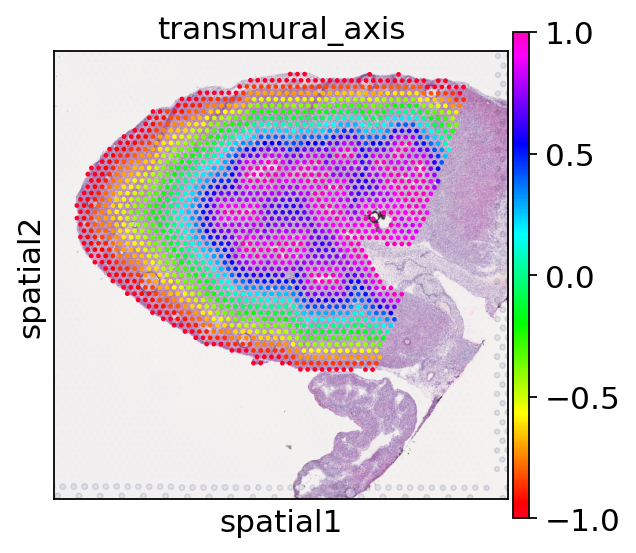

In [36]:
slide_id = 'HCAHeartST11605165'
slide = select_multislide(adata_oct_healthy, [slide_id])
sc.pl.spatial(slide,color=['transmural_axis'],cmap='gist_rainbow',show=False)
plt.savefig(f"{figdir}/visium_tm-axis_euploid_{slide_id}.pdf", bbox_inches="tight",dpi=300)

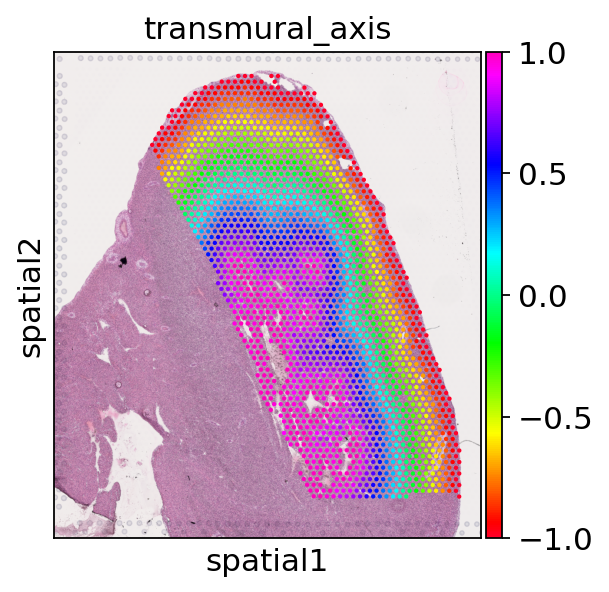

In [38]:
slide_id = 'HCAHeartST13162336'
slide = select_multislide(adata_oct_t21, [slide_id])
sc.pl.spatial(slide,color=['transmural_axis'],cmap='gist_rainbow',show=False)
plt.savefig(f"{figdir}/visium_tm-axis_t21_{slide_id}.pdf", bbox_inches="tight",dpi=300)

# Plot cells along the axis and time

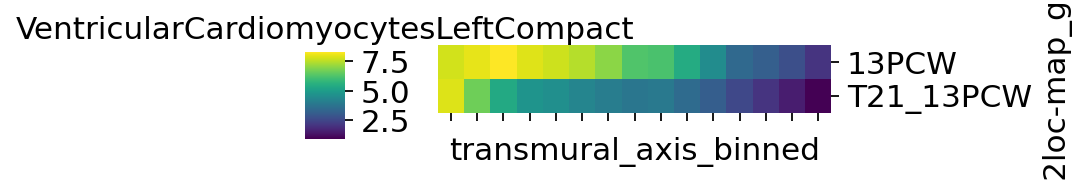

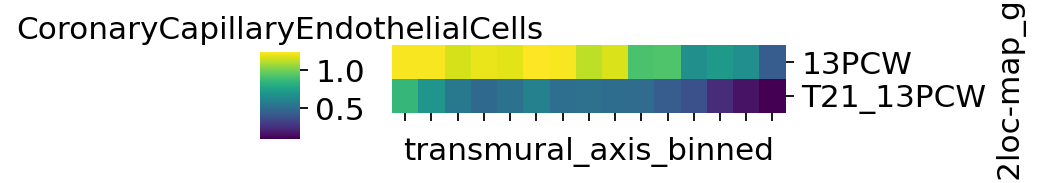

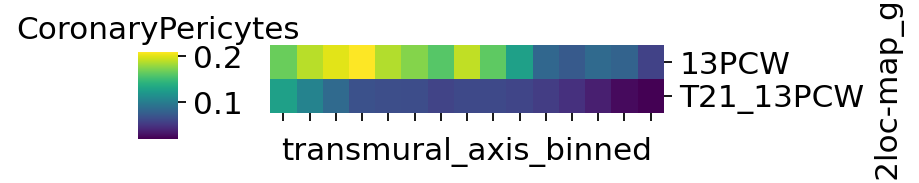

In [47]:
features_to_plot = ['VentricularCardiomyocytesLeftCompact',
                    'CoronaryCapillaryEndothelialCells','CoronaryPericytes'
                   ]

for feature in features_to_plot:
    tissueaxis.plot_axis_split(adata_oct,
                               feature_to_plot=feature,
                               feature_type='celltype',
                               min_max_scale=False,
                               splitby='cell2loc-map_group',
                               groups_order=['13PCW','T21_13PCW'],
                               figsize=(5, 3),
                               cbar_pos=(0, 0.7, 0.05, 0.18),
                               save=f'{figdir}/tm-axis_cell2loc_t21_{feature}.pdf'
                              )

In [45]:
?tissueaxis.plot_axis_split

Signature:
tissueaxis.plot_axis_split(
    adata,
    feature_to_plot,
    splitby,
    groups_order=None,
    axis_col='transmural_axis',
    n_bin=15,
    feature_type='gene',
    min_max_scale=True,
    row_cluster=False,
    figsize=(3, 8),
    cbar_pos=(0, 0.5, 0.05, 0.18),
    cmap='viridis',
    xticklabels=True,
    yticklabels=True,
    title=None,
    save=None,
    save_dpi=300,
    **kwargs,
)
Docstring: <no docstring>
File:      /nfs/team205/kk18/function/python/tissueaxis.py
Type:      function